In this tutorial, we will show best practices in using PathML from start to finish in training and evaluating two kinds of models, a classification model and a segmentation model, on a subset of whole-slide images that come from the CAMELYON16 dataset. These images show breast lymph nodes, and the task is to identify slides and/or regions of the slides which contain breast cancer metastases. We have ground truth annotations for all slides from expert pathologists. Although the full dataset contains 400 WSIs, we have created a microdataset of 18 of these slides for the purposes of this tutorial: 6 training slides, 6 validation slides, and 6 testing slides, each with 3 metastasis-containing/tumor slides and 3 negative slides.

First, we must import the libraries we need to run this tutorial. Please change the pathml and pathml-tutorial paths to your installation paths (indicated below with comments). PathML can be downloaded from here: https://github.com/markowetzlab/pathml

NOTE: If during the PathML import below, an error occurs with a message referencing something from libvips being missing, this is an issue with installing pyvips via pip. To solve this issue, run the following command inside your pathml-env conda environment to install the conda distribution of pyvips:

```conda install -c conda-forge pyvips```

In [1]:
import glob
import os
import pickle
import sys
from pathlib import Path
import random
from tqdm import tqdm
from statannotations.Annotator import Annotator

# change these to your local paths
sys.path.append('/home/cri.camres.org/berman01/Documents/pathml') # not necessary if you install PathML with pip
#sys.path.append('/path/to/pathml-tutorial/Pytorch-UNet')

from pathml.slide import Slide

from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import albumentations as A
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import time
#import logging

#from unet import UNet
#from eval import eval_net
#from utils.dataset import PathmlSegmentationDataset, visualizeSegmentationAugmentation
#from torch.utils.data import DataLoader, random_split
#from dice_loss import dice_coeff

Let's define some constants and paths and make some directories we'll need.

Make sure to change the path to the analysis directory (analysis_dir_path) to the directory where you will be working on your machine (same with the the path to wsi_data)!

In [2]:
# change to your local paths
analysis_dir_path = '/media/berman01/Expansion/benchmark_deep_tissue_detector'
wsi_path = '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis'

pathml_slide_dir_path = os.path.join(analysis_dir_path, 'pathml_slides')
annotations_dir_path = os.path.join(analysis_dir_path, 'annotations')
plot_dir_path = os.path.join(analysis_dir_path, 'plots')

os.makedirs(analysis_dir_path, exist_ok=True)
os.makedirs(pathml_slide_dir_path, exist_ok=True)
os.makedirs(annotations_dir_path, exist_ok=True)
os.makedirs(os.path.join(analysis_dir_path, 'results'), exist_ok=True)

tcga_tgct_cases = ['TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6', 
         'TCGA-2G-AAHN-01Z-00-DX1.B5CCB104-C436-4B80-8F47-EB9C7D13ACF0', 
         'TCGA-2G-AAKD-01Z-00-DX1.137A7B81-38C0-4715-BF9A-64BDB219DB9A', 
         'TCGA-2G-AAKO-05Z-00-DX1.2668F339-535C-4981-ADF7-9B47C15ED272', 
         'TCGA-YU-A94D-01Z-00-DX1.9B1832C3-F7CA-410A-AC74-28FCB282D05D',
        'TCGA-XE-A8H1-01A-01-TS1.12D10019-B0AC-4476-88F1-6996102A0D22']
camelyon_cases = ['normal_004', 'normal_042', 'tumor_021', 'tumor_031', 'tumor_051', 'tumor_092']
occams_cases = ['OC-AH-005_OGD_1-III-IV-MAYBE-HGD', 'OC-AH-005_OGD_1-I-II-MAYBE-HGD',
               'OC-AH-005_OGD_2-III-IV', 'OC-AH-124_OGD_K-I-II', 'OC-AH-153_OGD_3-III',
               'OC-AH-645_OGD_A1-SRS']
best_cases = ['BEST2 CAM 0003 HE - 2020-11-11 15.59.22', 'BEST2 CAM 0007 HE - 2020-11-11 16.28.24',
             'BEST2 CAM 0419 R1 P53 - LOOKS WEIRD 2021-06-08 14.08.34', 'BEST2 CDD 0004 R1 P53 - ARTIFACT EVERYWHERE 2021-06-08 13.36.39',
             'BEST2 NEW 0027 HE - LARGE ARTIFACT - 2020-11-12 16.56.07', 'BEST2 NEW 0189 P53 - MASSIVE ARTIFACT MAYBE RESCAN - 2020-12-29 21.11.36']
tcga_prad_cases = ['TCGA-YL-A8SL-01Z-00-DX2.F64D1539-E590-4B51-96B4-1F95CAE6E33A', 'TCGA-YL-A8SJ-01Z-00-DX2.36E46E11-79CA-4356-B68F-F387219B3D16',
                  'TCGA-YL-A8SI-01Z-00-DX1.35E5FB1A-9AAC-4942-892B-E9D80F6BDA23', 'TCGA-G9-6378-01A-01-BS1.bc59e095-f3ab-4a6e-8cef-ea7fc76abec8',
                  'TCGA-G9-7509-01Z-00-DX1.D75B78D5-F5B9-4684-9FE0-C7279122D66F', 'TCGA-G9-6333-11A-01-TS1.924c9301-78b6-4330-be95-533b25cf1a91']
tcga_misc_cases = ['TCGA-P3-A6T6-01Z-00-DX1.4873798C-A2AD-40D5-B5B3-FCF75735C4F3', 'TCGA-P3-A6T8-01Z-00-DX1.E3B6BA9A-3E96-4CCD-9C0F-52E9D27F1350',
                  'TCGA-SR-A6MX-01Z-00-DX1.2642CBB2-65ED-48E9-BC30-D2F3F5D4D8B3', 'TCGA-BA-A6DF-01Z-00-DX1.AAA638F5-C794-441B-A034-30AD8CC72573',
                  'TCGA-DQ-7590-01Z-00-DX1.8319DF99-1663-48DE-BB6A-A156FBAC2EA1', 'TCGA-FA-A82F-01Z-00-DX1.6D1B9A0A-FAA1-4E4D-9280-3D87F9929972']

cases = tcga_tgct_cases + camelyon_cases + occams_cases + best_cases + tcga_prad_cases + tcga_misc_cases
wsi_paths = [os.path.join(wsi_path, case+'.svs') for case in tcga_tgct_cases]+[os.path.join(wsi_path, case+'.tif') for case in camelyon_cases]+[os.path.join(wsi_path, case+'.svs') for case in occams_cases]+[os.path.join(wsi_path, case+'.ndpi') for case in best_cases]+[os.path.join(wsi_path, case+'.svs') for case in tcga_prad_cases]+[os.path.join(wsi_path, case+'.svs') for case in tcga_misc_cases] 
print(wsi_paths)
#print(wsi_paths[12:])


PermissionError: [Errno 13] Permission denied: '/media/berman01/Expansion'

First we'll define a pathml Slide object for each whole-slide image (WSI). We can use PathML to break the image up into tiles of the desired size and separate all tiles showing background and artifact from those showing actual tissue. We can then add annotations for our ground truth tissue regions. When adding annotations, make sure to set the name of the class for "donut hole" or negative regions to extract from other annotations with the negativeClass argument of Slide.addAnnotations().

NOTE: Some users may find that progress freezes as the first WSI is being run through Slide.detectTissue(). This is a PyTorch issue. If this happens to you, set numWorkers=0 in the Slide.detectTissue() call, and tissue detection should proceed (albeit slowly). The default of numWorkers in Slide.detectTissue() is 16. (2m 31s)

In [8]:
start_time = time.time()

tile_size = 500 # pixels

for wsi_path in wsi_paths:#wsi_paths[:24]:#wsi_paths:
    case = Path(wsi_path).stem
    pathml_slide = Slide(wsi_path, level=0).setTileProperties(tileSize=tile_size)
    
    annotation_path = os.path.join(analysis_dir_path, 'annotations', case+'.xml')
    print(annotation_path)
    
    pathml_slide.addAnnotations(annotation_path, negativeClass='negative')
    
    if case in camelyon_cases:
        pathml_slide.detectForeground(level=4)
    elif case in tcga_tgct_cases:
        pathml_slide.detectForeground(level=2)
    elif case in occams_cases:
        pathml_slide.detectForeground(level=2)
    elif case in best_cases:
        pathml_slide.detectForeground(level=4)
    elif case in tcga_prad_cases:
        pathml_slide.detectForeground(level=2)
    elif case in tcga_misc_cases:
        pathml_slide.detectForeground(level=2)
        
    if case in tcga_tgct_cases + camelyon_cases + occams_cases + best_cases:
        pathml_slide.detectTissue(tissueDetectionLevel=1)
    else:
        pathml_slide.detectTissue(tissueDetectionLevel=0)
    
    pathml_slide.save(folder=pathml_slide_dir_path)
    
time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6.xml
Scale: 1.0
xml file valid - 7 annotation(s) found.
6 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6.svs


100%|██████████| 80/80 [00:11<00:00,  6.79it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-2G-AAHN-01Z-00-DX1.B5CCB104-C436-4B80-8F47-EB9C7D13ACF0.xml
Scale: 1.0
xml file valid - 1 annotation(s) found.
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAHN-01Z-00-DX1.B5CCB104-C436-4B80-8F47-EB9C7D13ACF0.svs


100%|██████████| 48/48 [00:08<00:00,  5.90it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-2G-AAKD-01Z-00-DX1.137A7B81-38C0-4715-BF9A-64BDB219DB9A.xml
Scale: 1.0
xml file valid - 2 annotation(s) found.
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAKD-01Z-00-DX1.137A7B81-38C0-4715-BF9A-64BDB219DB9A.svs


100%|██████████| 94/94 [00:13<00:00,  6.74it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-2G-AAKO-05Z-00-DX1.2668F339-535C-4981-ADF7-9B47C15ED272.xml
Scale: 1.0
xml file valid - 6 annotation(s) found.
5 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAKO-05Z-00-DX1.2668F339-535C-4981-ADF7-9B47C15ED272.svs


100%|██████████| 88/88 [00:13<00:00,  6.75it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-YU-A94D-01Z-00-DX1.9B1832C3-F7CA-410A-AC74-28FCB282D05D.xml
Scale: 1.0
xml file valid - 6 annotation(s) found.
3 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-YU-A94D-01Z-00-DX1.9B1832C3-F7CA-410A-AC74-28FCB282D05D.svs


100%|██████████| 109/109 [00:24<00:00,  4.50it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-XE-A8H1-01A-01-TS1.12D10019-B0AC-4476-88F1-6996102A0D22.xml
Scale: 1.0
xml file valid - 8 annotation(s) found.
2 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-XE-A8H1-01A-01-TS1.12D10019-B0AC-4476-88F1-6996102A0D22.svs


100%|██████████| 52/52 [00:11<00:00,  4.66it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/normal_004.xml
Scale: 1.0
xml file valid - 39 annotation(s) found.
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/normal_004.tif


100%|██████████| 1002/1002 [01:16<00:00, 13.13it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/normal_042.xml
Scale: 1.0
xml file valid - 5 annotation(s) found.
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/normal_042.tif


100%|██████████| 1007/1007 [01:13<00:00, 13.72it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/tumor_021.xml
Scale: 1.0
xml file valid - 9 annotation(s) found.
5 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/tumor_021.tif


100%|██████████| 1022/1022 [02:47<00:00,  6.12it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/tumor_031.xml
Scale: 1.0
xml file valid - 10 annotation(s) found.
4 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/tumor_031.tif


100%|██████████| 1026/1026 [01:30<00:00, 11.28it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/tumor_051.xml
Scale: 1.0
xml file valid - 6 annotation(s) found.
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/tumor_051.tif


100%|██████████| 1026/1026 [03:46<00:00,  4.54it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/tumor_092.xml
Scale: 1.0
xml file valid - 16 annotation(s) found.
11 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/tumor_092.tif


100%|██████████| 983/983 [02:59<00:00,  5.49it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/OC-AH-005_OGD_1-III-IV-MAYBE-HGD.xml
Scale: 1.0
xml file valid - 9 annotation(s) found.
1 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/OC-AH-005_OGD_1-III-IV-MAYBE-HGD.svs


100%|██████████| 69/69 [00:21<00:00,  3.19it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/OC-AH-005_OGD_1-I-II-MAYBE-HGD.xml
Scale: 1.0
xml file valid - 15 annotation(s) found.
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/OC-AH-005_OGD_1-I-II-MAYBE-HGD.svs


100%|██████████| 105/105 [00:33<00:00,  3.10it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/OC-AH-005_OGD_2-III-IV.xml
Scale: 1.0
xml file valid - 35 annotation(s) found.
6 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/OC-AH-005_OGD_2-III-IV.svs


100%|██████████| 77/77 [00:23<00:00,  3.23it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/OC-AH-124_OGD_K-I-II.xml
Scale: 1.0
xml file valid - 22 annotation(s) found.
3 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/OC-AH-124_OGD_K-I-II.svs


100%|██████████| 121/121 [00:34<00:00,  3.51it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/OC-AH-153_OGD_3-III.xml
Scale: 1.0
xml file valid - 11 annotation(s) found.
6 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/OC-AH-153_OGD_3-III.svs


100%|██████████| 40/40 [00:11<00:00,  3.34it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/OC-AH-645_OGD_A1-SRS.xml
Scale: 1.0
xml file valid - 36 annotation(s) found.
4 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/OC-AH-645_OGD_A1-SRS.svs


100%|██████████| 96/96 [00:26<00:00,  3.60it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/BEST2 CAM 0003 HE - 2020-11-11 15.59.22.xml
Scale: 1.0
xml file valid - 12 annotation(s) found.
10 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/BEST2 CAM 0003 HE - 2020-11-11 15.59.22.ndpi


100%|██████████| 470/470 [00:39<00:00, 11.91it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/BEST2 CAM 0007 HE - 2020-11-11 16.28.24.xml
Scale: 1.0
xml file valid - 29 annotation(s) found.
18 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/BEST2 CAM 0007 HE - 2020-11-11 16.28.24.ndpi


100%|██████████| 864/864 [02:00<00:00,  7.18it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/BEST2 CAM 0419 R1 P53 - LOOKS WEIRD 2021-06-08 14.08.34.xml
Scale: 1.0
xml file valid - 4 annotation(s) found.
3 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/BEST2 CAM 0419 R1 P53 - LOOKS WEIRD 2021-06-08 14.08.34.ndpi


100%|██████████| 256/256 [00:20<00:00, 12.32it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/BEST2 CDD 0004 R1 P53 - ARTIFACT EVERYWHERE 2021-06-08 13.36.39.xml
Scale: 1.0
xml file valid - 23 annotation(s) found.
12 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/BEST2 CDD 0004 R1 P53 - ARTIFACT EVERYWHERE 2021-06-08 13.36.39.ndpi


100%|██████████| 152/152 [00:13<00:00, 11.36it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/BEST2 NEW 0027 HE - LARGE ARTIFACT - 2020-11-12 16.56.07.xml
Scale: 1.0
xml file valid - 17 annotation(s) found.
4 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/BEST2 NEW 0027 HE - LARGE ARTIFACT - 2020-11-12 16.56.07.ndpi


100%|██████████| 691/691 [01:41<00:00,  6.79it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/BEST2 NEW 0189 P53 - MASSIVE ARTIFACT MAYBE RESCAN - 2020-12-29 21.11.36.xml
Scale: 1.0
xml file valid - 15 annotation(s) found.
14 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/BEST2 NEW 0189 P53 - MASSIVE ARTIFACT MAYBE RESCAN - 2020-12-29 21.11.36.ndpi


100%|██████████| 345/345 [00:28<00:00, 12.00it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-YL-A8SL-01Z-00-DX2.F64D1539-E590-4B51-96B4-1F95CAE6E33A.xml
Scale: 1.0
xml file valid - 45 annotation(s) found.
34 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-YL-A8SL-01Z-00-DX2.F64D1539-E590-4B51-96B4-1F95CAE6E33A.svs


100%|██████████| 120/120 [00:17<00:00,  6.74it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-YL-A8SJ-01Z-00-DX2.36E46E11-79CA-4356-B68F-F387219B3D16.xml
Scale: 1.0
xml file valid - 40 annotation(s) found.
36 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-YL-A8SJ-01Z-00-DX2.36E46E11-79CA-4356-B68F-F387219B3D16.svs


100%|██████████| 103/103 [00:15<00:00,  6.76it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-YL-A8SI-01Z-00-DX1.35E5FB1A-9AAC-4942-892B-E9D80F6BDA23.xml
Scale: 1.0
xml file valid - 24 annotation(s) found.
19 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-YL-A8SI-01Z-00-DX1.35E5FB1A-9AAC-4942-892B-E9D80F6BDA23.svs


100%|██████████| 67/67 [00:10<00:00,  6.62it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-G9-6378-01A-01-BS1.bc59e095-f3ab-4a6e-8cef-ea7fc76abec8.xml
Scale: 1.0
xml file valid - 6 annotation(s) found.
5 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-G9-6378-01A-01-BS1.bc59e095-f3ab-4a6e-8cef-ea7fc76abec8.svs


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-G9-7509-01Z-00-DX1.D75B78D5-F5B9-4684-9FE0-C7279122D66F.xml
Scale: 1.0
xml file valid - 6 annotation(s) found.
2 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-G9-7509-01Z-00-DX1.D75B78D5-F5B9-4684-9FE0-C7279122D66F.svs


100%|██████████| 80/80 [00:16<00:00,  4.74it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-G9-6333-11A-01-TS1.924c9301-78b6-4330-be95-533b25cf1a91.xml
Scale: 1.0
xml file valid - 10 annotation(s) found.
7 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-G9-6333-11A-01-TS1.924c9301-78b6-4330-be95-533b25cf1a91.svs


100%|██████████| 16/16 [00:05<00:00,  2.91it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-P3-A6T6-01Z-00-DX1.4873798C-A2AD-40D5-B5B3-FCF75735C4F3.xml
Scale: 1.0
xml file valid - 44 annotation(s) found.
26 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-P3-A6T6-01Z-00-DX1.4873798C-A2AD-40D5-B5B3-FCF75735C4F3.svs


100%|██████████| 163/163 [00:47<00:00,  3.42it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-P3-A6T8-01Z-00-DX1.E3B6BA9A-3E96-4CCD-9C0F-52E9D27F1350.xml
Scale: 1.0
xml file valid - 22 annotation(s) found.
9 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-P3-A6T8-01Z-00-DX1.E3B6BA9A-3E96-4CCD-9C0F-52E9D27F1350.svs


100%|██████████| 218/218 [01:04<00:00,  3.37it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-SR-A6MX-01Z-00-DX1.2642CBB2-65ED-48E9-BC30-D2F3F5D4D8B3.xml
Scale: 1.0
xml file valid - 42 annotation(s) found.
32 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-SR-A6MX-01Z-00-DX1.2642CBB2-65ED-48E9-BC30-D2F3F5D4D8B3.svs


100%|██████████| 67/67 [00:07<00:00,  9.54it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-BA-A6DF-01Z-00-DX1.AAA638F5-C794-441B-A034-30AD8CC72573.xml
Scale: 1.0
xml file valid - 22 annotation(s) found.
13 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-BA-A6DF-01Z-00-DX1.AAA638F5-C794-441B-A034-30AD8CC72573.svs


100%|██████████| 198/198 [00:25<00:00,  7.74it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-DQ-7590-01Z-00-DX1.8319DF99-1663-48DE-BB6A-A156FBAC2EA1.xml
Scale: 1.0
xml file valid - 111 annotation(s) found.
25 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-DQ-7590-01Z-00-DX1.8319DF99-1663-48DE-BB6A-A156FBAC2EA1.svs


100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/TCGA-FA-A82F-01Z-00-DX1.6D1B9A0A-FAA1-4E4D-9280-3D87F9929972.xml
Scale: 1.0
xml file valid - 15 annotation(s) found.
1 negative annotation(s) found
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-FA-A82F-01Z-00-DX1.6D1B9A0A-FAA1-4E4D-9280-3D87F9929972.svs


100%|██████████| 141/141 [00:29<00:00,  4.81it/s]


Complete in 40m 50s


Let's check to make sure the tissue detector is filtering the tiles we want and compare the results to Otsu's method and the triangle algorithm on our six validation slides: (48s)

/home/cri.camres.org/berman01/Documents/pathml/pathml/slide.py:2184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


MemoryError: Unable to allocate 4.93 GiB for an array with shape (54400, 24320, 4) and data type bool

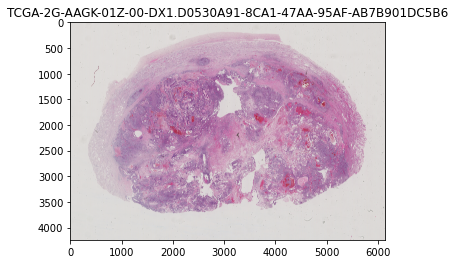

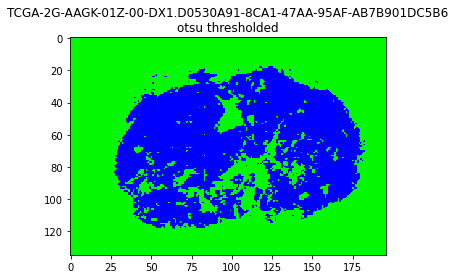

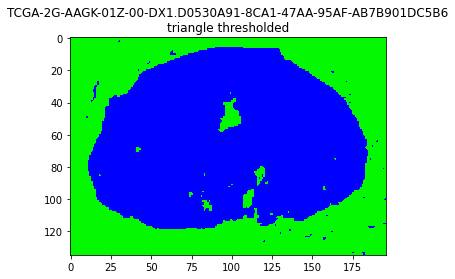

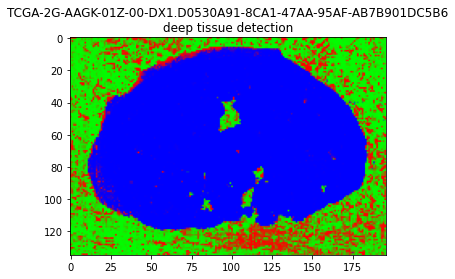

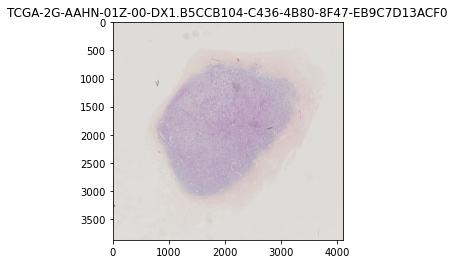

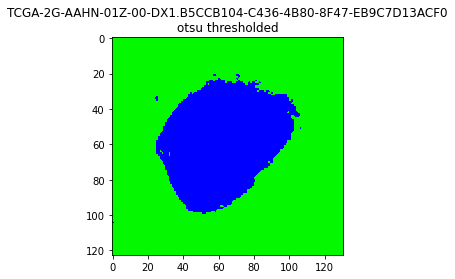

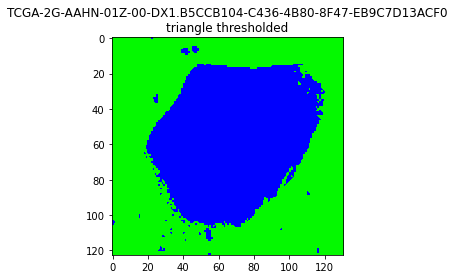

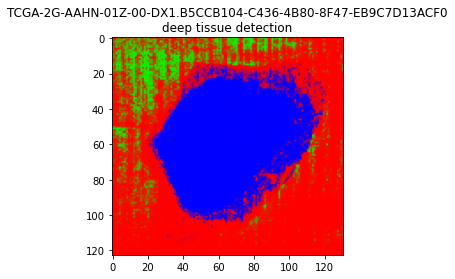

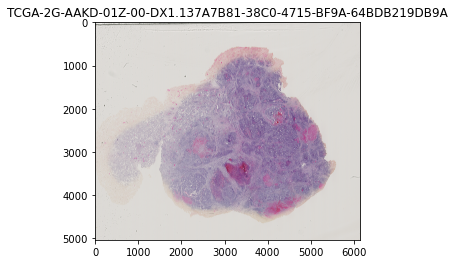

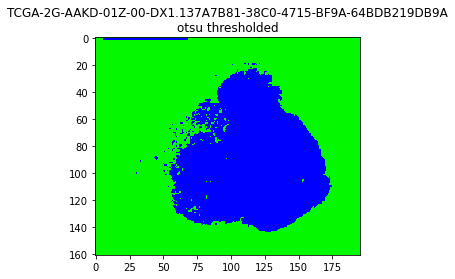

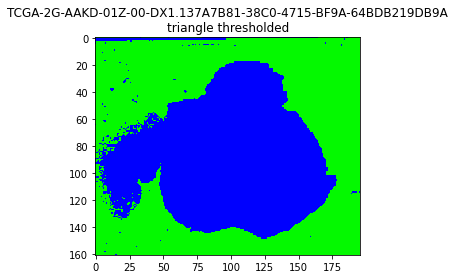

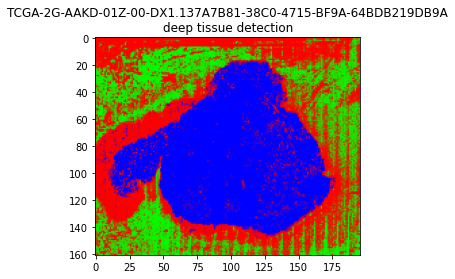

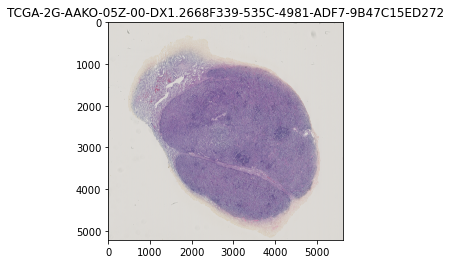

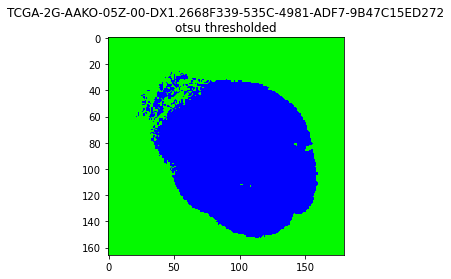

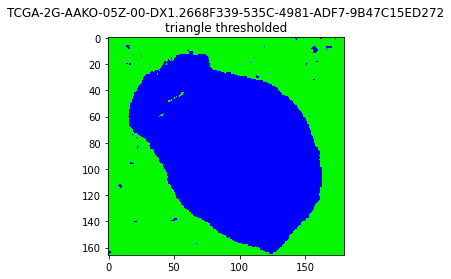

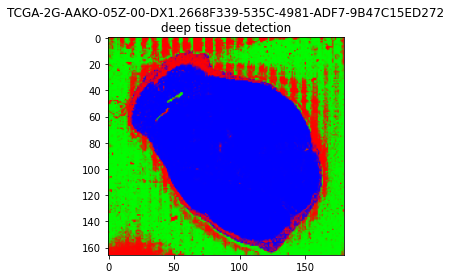

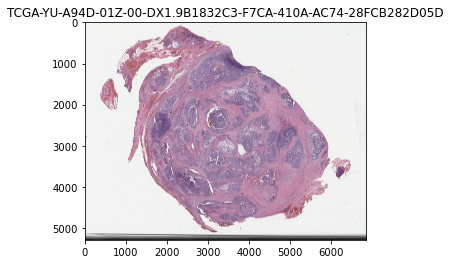

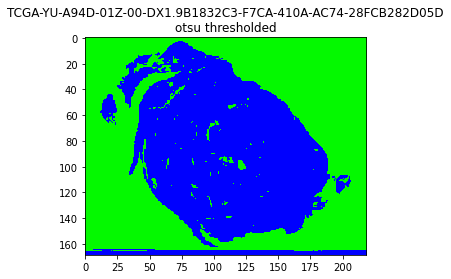

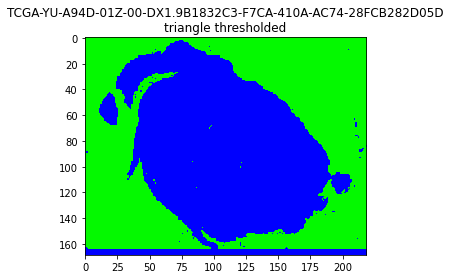

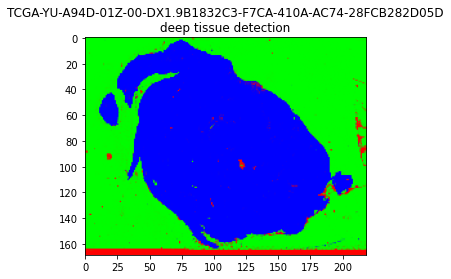

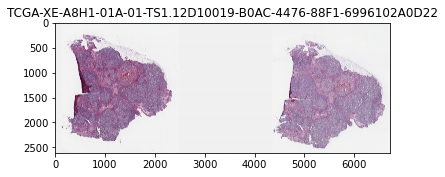

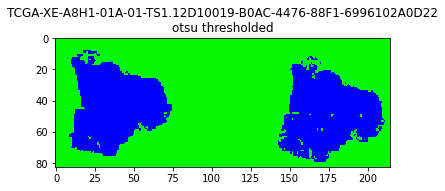

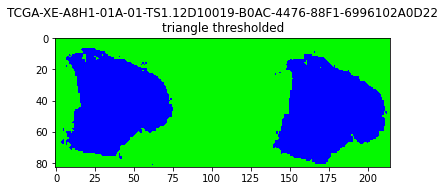

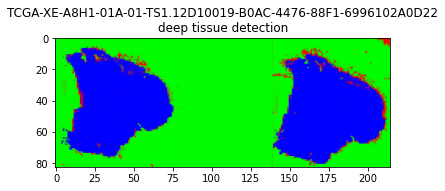

MemoryError: Unable to allocate 4.90 GiB for an array with shape (54656, 24064, 4) and data type uint8

<Figure size 432x288 with 1 Axes>

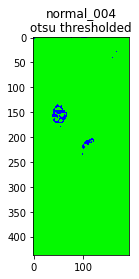

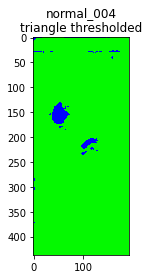

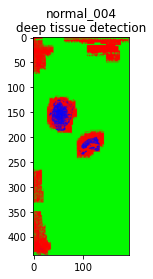

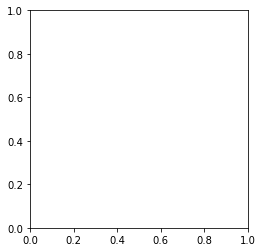

In [48]:
for case in cases[:24]:
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))
    pathml_slide.visualizeThumbnail(folder=os.path.join(analysis_dir_path, 'results'), level=2)
    pathml_slide.visualizeForeground('otsu', folder=os.path.join(analysis_dir_path, 'results'))
    pathml_slide.visualizeForeground('triangle', folder=os.path.join(analysis_dir_path, 'results'))
    pathml_slide.visualizeTissueDetection(folder=os.path.join(analysis_dir_path, 'results'))

We see that in addition to not having any artifact detection capabilities, Otsu's method excludes lighter-colored tissue from the central region of the upper tissue section, whereas the triangle method erroniously includes dark slide artifact regions around the edge of the slide to be tissue. The deep tissue detector seems to be performing well, and we can verify this by checking all of the deep tissue detector class map images we generated alongside all of our trainval slides in the same directory we stored our PathML slides.

Now we can iterate over all tiles in the WSIs to compare the Otsu, triangle, and deep tissue detector results for identifying tissue regions with the annotated ground truth

In [55]:
start_time = time.time()

ground_truth_tissue_overlaps_all_slides = {}
otsu_classifications_all_slides = {}
triangle_classifications_all_slides = {}
dtd_tissue_probs_all_slides = {}
dtd_artifact_probs_all_slides = {}
dtd_background_probs_all_slides = {}

total_tiles = 0

for case in cases:
    ground_truth_tissue_overlaps = []
    otsu_classifications = []
    triangle_classifications = []
    dtd_tissue_probs = []
    dtd_artifact_probs = []
    dtd_background_probs = []
    
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))

    for tile_coords in pathml_slide.iterateTiles():
        tile_data = pathml_slide.tileDictionary[tile_coords]

        ground_truth_tissue_overlaps.append(tile_data['tissueOverlap'])
        otsu_classifications.append(tile_data['foregroundOtsu'])
        triangle_classifications.append(tile_data['foregroundTriangle'])
        dtd_tissue_probs.append(tile_data['tissueLevel'])
        dtd_artifact_probs.append(tile_data['artifactLevel'])
        dtd_background_probs.append(tile_data['backgroundLevel'])
    
    print(case)
    print('num tiles:', len(ground_truth_tissue_overlaps))
    total_tiles += len(ground_truth_tissue_overlaps)
    
    ground_truth_tissue_overlaps_all_slides[case] = ground_truth_tissue_overlaps
    otsu_classifications_all_slides[case] = otsu_classifications
    triangle_classifications_all_slides[case] = triangle_classifications
    dtd_tissue_probs_all_slides[case] = dtd_tissue_probs
    dtd_artifact_probs_all_slides[case] = dtd_artifact_probs
    dtd_background_probs_all_slides[case] = dtd_background_probs
        

print('Total tiles:', total_tiles)
time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6
num tiles: 26460
TCGA-2G-AAHN-01Z-00-DX1.B5CCB104-C436-4B80-8F47-EB9C7D13ACF0
num tiles: 16113
TCGA-2G-AAKD-01Z-00-DX1.137A7B81-38C0-4715-BF9A-64BDB219DB9A
num tiles: 31556
TCGA-2G-AAKO-05Z-00-DX1.2668F339-535C-4981-ADF7-9B47C15ED272
num tiles: 29880
TCGA-YU-A94D-01Z-00-DX1.9B1832C3-F7CA-410A-AC74-28FCB282D05D
num tiles: 37011
TCGA-XE-A8H1-01A-01-TS1.12D10019-B0AC-4476-88F1-6996102A0D22
num tiles: 17845
normal_004
num tiles: 83904
normal_042
num tiles: 84390
tumor_021
num tiles: 85995
tumor_031
num tiles: 86190
tumor_051
num tiles: 86190
tumor_092
num tiles: 82212
OC-AH-005_OGD_1-III-IV-MAYBE-HGD
num tiles: 23493
OC-AH-005_OGD_1-I-II-MAYBE-HGD
num tiles: 35611
OC-AH-005_OGD_2-III-IV
num tiles: 26499
OC-AH-124_OGD_K-I-II
num tiles: 41748
OC-AH-153_OGD_3-III
num tiles: 13662
OC-AH-645_OGD_A1-SRS
num tiles: 32634
BEST2 CAM 0003 HE - 2020-11-11 15.59.22
num tiles: 39760
BEST2 CAM 0007 HE - 2020-11-11 16.28.24
num tiles: 72496
BES

Next let's use these data to calculate the accuracy of each tissue detection method (Otsu, triangle, deep tissue detector) for each slide

In [4]:
#print('GROUND TRUTH')
#print(ground_truth_tissue_overlaps_all_slides['TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6'])
#print('DEEP TISSUE DETECTOR')
#print(dtd_tissue_probs_all_slides['TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6'])

# sensitivity to tissue class
#methods = ['deep_tissue_detector', 'otsu', 'triangle']
#results = {case: {method: {}} for case in cases}
results = {'case_names': cases, 
          'deep_tissue_detector_acc': [], 'otsu_acc': [], 'triangle_acc': [],
          'deep_tissue_detector_bal_acc': [], 'otsu_bal_acc': [], 'triangle_bal_acc': [],
           'deep_tissue_detector_tissue_prec': [], 'otsu_tissue_prec': [], 'triangle_tissue_prec': [],
           'deep_tissue_detector_tissue_rec': [], 'otsu_tissue_rec': [], 'triangle_tissue_rec': [],
           'deep_tissue_detector_tissue_f1': [], 'otsu_tissue_f1': [], 'triangle_tissue_f1': [],
        'deep_tissue_detector_background_prec': [], 'otsu_background_prec': [], 'triangle_background_prec': [],
           'deep_tissue_detector_background_rec': [], 'otsu_background_rec': [], 'triangle_background_rec': [],
           'deep_tissue_detector_background_f1': [], 'otsu_background_f1': [], 'triangle_background_f1': []}

for case in cases:
    ground_truth = [i > 0.9 for i in ground_truth_tissue_overlaps_all_slides[case]]
    deep_tissue_detector = [i > 0.3 for i in dtd_tissue_probs_all_slides[case]]
    #print(deep_tissue_detector)
    otsu = otsu_classifications_all_slides[case]
    triangle = triangle_classifications_all_slides[case]
    
    results['deep_tissue_detector_acc'].append(accuracy_score(ground_truth, deep_tissue_detector))
    results['otsu_acc'].append(accuracy_score(ground_truth, otsu))
    results['triangle_acc'].append(accuracy_score(ground_truth, triangle))
    
    results['deep_tissue_detector_bal_acc'].append(balanced_accuracy_score(ground_truth, deep_tissue_detector))
    results['otsu_bal_acc'].append(balanced_accuracy_score(ground_truth, otsu))
    results['triangle_bal_acc'].append(balanced_accuracy_score(ground_truth, triangle))
    
    results['deep_tissue_detector_tissue_prec'].append(precision_score(ground_truth, deep_tissue_detector, pos_label=True, average='binary'))
    results['otsu_tissue_prec'].append(precision_score(ground_truth, otsu, pos_label=True, average='binary'))
    results['triangle_tissue_prec'].append(precision_score(ground_truth, triangle, pos_label=True, average='binary'))
    
    results['deep_tissue_detector_tissue_rec'].append(recall_score(ground_truth, deep_tissue_detector, pos_label=True, average='binary'))
    results['otsu_tissue_rec'].append(recall_score(ground_truth, otsu, pos_label=True, average='binary'))
    results['triangle_tissue_rec'].append(recall_score(ground_truth, triangle, pos_label=True, average='binary'))
    
    results['deep_tissue_detector_tissue_f1'].append(f1_score(ground_truth, deep_tissue_detector, pos_label=True, average='binary'))
    results['otsu_tissue_f1'].append(f1_score(ground_truth, otsu, pos_label=True, average='binary'))
    results['triangle_tissue_f1'].append(f1_score(ground_truth, triangle, pos_label=True, average='binary'))
    
    results['deep_tissue_detector_background_prec'].append(precision_score(ground_truth, deep_tissue_detector, pos_label=False, average='binary'))
    results['otsu_background_prec'].append(precision_score(ground_truth, otsu, pos_label=False, average='binary'))
    results['triangle_background_prec'].append(precision_score(ground_truth, triangle, pos_label=False, average='binary'))
    
    results['deep_tissue_detector_background_rec'].append(recall_score(ground_truth, deep_tissue_detector, pos_label=False, average='binary'))
    results['otsu_background_rec'].append(recall_score(ground_truth, otsu, pos_label=False, average='binary'))
    results['triangle_background_rec'].append(recall_score(ground_truth, triangle, pos_label=False, average='binary'))
    
    results['deep_tissue_detector_background_f1'].append(f1_score(ground_truth, deep_tissue_detector, pos_label=False, average='binary'))
    results['otsu_background_f1'].append(f1_score(ground_truth, otsu, pos_label=False, average='binary'))
    results['triangle_background_f1'].append(f1_score(ground_truth, triangle, pos_label=False, average='binary'))
    
    
    
    
    
    
    
    print(case)
    print('deep tissue detector accuracy: ', accuracy_score(ground_truth, deep_tissue_detector))
    print('otsu accuracy: ', accuracy_score(ground_truth, otsu))
    print('triangle accuracy: ', accuracy_score(ground_truth, triangle))
    print()

    


TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6
deep tissue detector accuracy:  0.9401360544217687
otsu accuracy:  0.8258503401360544
triangle accuracy:  0.9697656840513983

TCGA-2G-AAHN-01Z-00-DX1.B5CCB104-C436-4B80-8F47-EB9C7D13ACF0
deep tissue detector accuracy:  0.9319183268168559
otsu accuracy:  0.8228138769937318
triangle accuracy:  0.9630112331657668

TCGA-2G-AAKD-01Z-00-DX1.137A7B81-38C0-4715-BF9A-64BDB219DB9A
deep tissue detector accuracy:  0.9619406768918748
otsu accuracy:  0.8414881480542528
triangle accuracy:  0.9628913677272151

TCGA-2G-AAKO-05Z-00-DX1.2668F339-535C-4981-ADF7-9B47C15ED272
deep tissue detector accuracy:  0.9607095046854083
otsu accuracy:  0.8998326639892905
triangle accuracy:  0.9841700133868808

TCGA-YU-A94D-01Z-00-DX1.9B1832C3-F7CA-410A-AC74-28FCB282D05D
deep tissue detector accuracy:  0.933668368863311
otsu accuracy:  0.9528788738483154
triangle accuracy:  0.9429899219151063

TCGA-XE-A8H1-01A-01-TS1.12D10019-B0AC-4476-88F1-6996102A0D22
deep 

In [86]:
for metric, metric_values in results.items():
    if metric is not 'case_names':
        print('Average '+metric+':', sum(metric_values)/len(metric_values))
        
pickle.dump(results, open("/home/cri.camres.org/berman01/Documents/pathml-tutorial/benchmark_deep_tissue_detector/results.p", "wb"))

Average deep_tissue_detector_acc: 0.9505910526460783
Average otsu_acc: 0.8547753476937227
Average triangle_acc: 0.8717735218496149
Average deep_tissue_detector_bal_acc: 0.9517060364889317
Average otsu_bal_acc: 0.7726221541354243
Average triangle_bal_acc: 0.8839006847237275
Average deep_tissue_detector_tissue_prec: 0.7593637298653793
Average otsu_tissue_prec: 0.6391405356743439
Average triangle_tissue_prec: 0.5983344455205573
Average deep_tissue_detector_tissue_rec: 0.9579529118129135
Average otsu_tissue_rec: 0.6154560029450535
Average triangle_tissue_rec: 0.8977101984592212
Average deep_tissue_detector_tissue_f1: 0.8284308533087924
Average otsu_tissue_f1: 0.591458468408131
Average triangle_tissue_f1: 0.6752553959011869
Average deep_tissue_detector_background_prec: 0.9831618248600292
Average otsu_background_prec: 0.8783062587328764
Average triangle_background_prec: 0.9607746951215302
Average deep_tissue_detector_background_rec: 0.9454591611649492
Average otsu_background_rec: 0.929788305

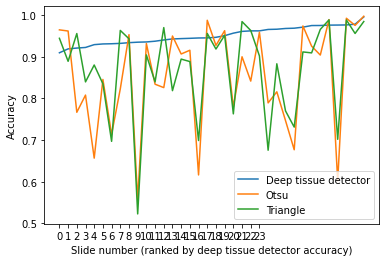

In [14]:
dtt_acc_sorted, otsu_acc_sorted, triangle_acc_sorted = zip(*sorted(zip(results['deep_tissue_detector_acc'], results['otsu_acc'], results['triangle_acc'])))

plt.plot(dtt_acc_sorted, label='Deep tissue detector')
plt.plot(otsu_acc_sorted, label='Otsu')
plt.plot(triangle_acc_sorted, label='Triangle')
plt.xlabel('Slide number (ranked by deep tissue detector accuracy)')
plt.ylabel('Accuracy')
plt.xticks(range(0,24))
plt.legend()
plt.show()

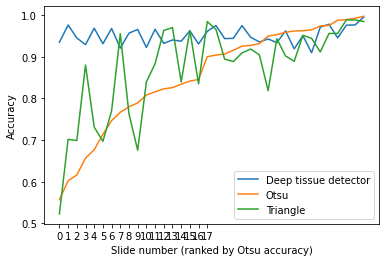

In [15]:
otsu_acc_sorted, dtt_acc_sorted, triangle_acc_sorted = zip(*sorted(zip(results['otsu_acc'], results['deep_tissue_detector_acc'], results['triangle_acc'])))

plt.plot(dtt_acc_sorted, label='Deep tissue detector')
plt.plot(otsu_acc_sorted, label='Otsu')
plt.plot(triangle_acc_sorted, label='Triangle')
plt.xlabel('Slide number (ranked by Otsu accuracy)')
plt.ylabel('Accuracy')
plt.xticks(range(0,18))
plt.legend()
plt.show()

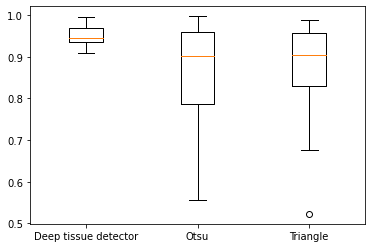

In [16]:
acc_dict = {"Deep tissue detector": results['deep_tissue_detector_acc'], 'Otsu': results['otsu_acc'], 'Triangle': results['triangle_acc']}
fig, ax = plt.subplots()
ax.boxplot(acc_dict.values())
ax.set_xticklabels(acc_dict.keys())
plt.show()

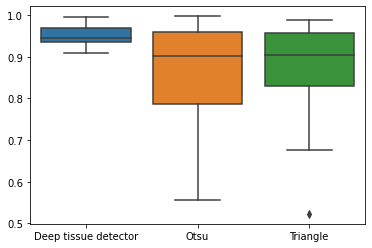

In [6]:
boxplot_df = pd.DataFrame(
    {'Deep tissue detector': results['deep_tissue_detector_acc'],
     'Otsu': results['otsu_acc'],
     'Triangle': results['triangle_acc']
    })

ax = sns.boxplot(data=boxplot_df)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Specificity_Deep tissue detector v.s. Specificity_Otsu: Wilcoxon test (paired samples), P_val=9.624e-01 stat=3.300e+02
Using zero_method  wilcox
Balanced accuracy_Deep tissue detector v.s. Balanced accuracy_Otsu: Wilcoxon test (paired samples), P_val=9.501e-07 stat=2.100e+01
Using zero_method  wilcox
Sensitivity_Deep tissue detector v.s. Sensitivity_Otsu: Wilcoxon test (paired samples), P_val=7.556e-07 stat=1.300e+01
Using zero_method  wilcox
Specificity_Deep tissue detector v.s. Specificity_Triangle: Wilcoxon test (paired samples), P_val=9.167e-04 stat=1.220e+02
Using zero_method  wilcox
Sensitivity_Deep tissue detector v.s. Sensitivity_Triangle: Wilcoxon test (paired samples), P_val=3.590e-01 stat=2.590e+02
Using zero_method  wilcox
Balanced accuracy_Deep tissue detector v.s. Balanced accuracy_Tri

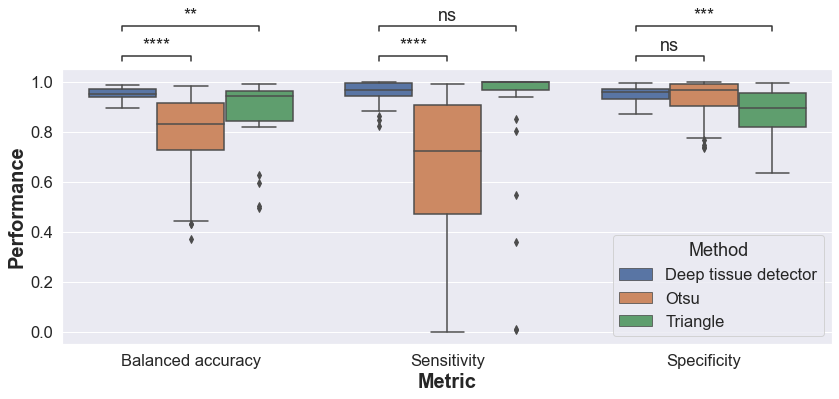

In [12]:
results = pickle.load(open("/home/cri.camres.org/berman01/Documents/pathml-tutorial/benchmark_deep_tissue_detector/results.p", 'rb'))


dtt_results = results['deep_tissue_detector_bal_acc']+results['deep_tissue_detector_tissue_rec']+results['deep_tissue_detector_background_rec']
otsu_results = results['otsu_bal_acc']+results['otsu_tissue_rec']+results['otsu_background_rec']
triangle_results = results['triangle_bal_acc']+results['triangle_tissue_rec']+results['triangle_background_rec']
metric_list = ['Balanced accuracy' for i in range(len(cases))]+['Sensitivity' for i in range(len(cases))]+['Specificity' for i in range(len(cases))]

boxplot_df = pd.DataFrame(
    {'Performance':dtt_results+otsu_results+triangle_results,
     'Method':['Deep tissue detector' for i in range(len(dtt_results))]+['Otsu' for i in range(len(otsu_results))]+['Triangle' for i in range(len(triangle_results))],
     'Metric': metric_list+metric_list+metric_list
    })

#print(boxplot_df)

box_pairs = [
    (('Balanced accuracy', 'Deep tissue detector'), ('Balanced accuracy', 'Otsu')),
    (('Balanced accuracy', 'Deep tissue detector'), ('Balanced accuracy', 'Triangle')),
    (('Sensitivity', 'Deep tissue detector'), ('Sensitivity', 'Otsu')),
    (('Sensitivity', 'Deep tissue detector'), ('Sensitivity', 'Triangle')),
    (('Specificity', 'Deep tissue detector'), ('Specificity', 'Otsu')),
    (('Specificity', 'Deep tissue detector'), ('Specificity', 'Triangle'))
]

plt.figure(figsize=(12,6))
sns.set(font_scale=1.5)
ax = sns.boxplot(x='Metric', y='Performance', hue='Method', data=boxplot_df)
ax.set_xlabel('Metric', fontsize=20, fontweight='bold')
ax.set_ylabel('Performance', fontsize=20, fontweight='bold')
test_results = add_stat_annotation(ax, data=boxplot_df, x='Metric', y='Performance', hue='Method', 
                                   box_pairs=box_pairs, test='Wilcoxon', comparisons_correction=None,
                                   text_format='star', loc='outside', verbose=2)
plt.tight_layout()
plt.savefig(os.path.join('/Users/berman01/Downloads/plots', 'performance_boxplot.png'))
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Specificity_Deep tissue detector vs. Specificity_Otsu: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:9.624e-01 Stat=3.300e+02
Balanced accuracy_Deep tissue detector vs. Balanced accuracy_Otsu: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:9.501e-07 Stat=2.100e+01
Sensitivity_Deep tissue detector vs. Sensitivity_Otsu: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:7.556e-07 Stat=1.300e+01
Specificity_Deep tissue detector vs. Specificity_Triangle: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:9.167e-04 Stat=1.220e+02
Sensitivity_Deep tissue detector vs. Sensitivity_Triangle: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.590e-01 Stat=2.590e+02
Balanced accuracy_Deep tissue dete

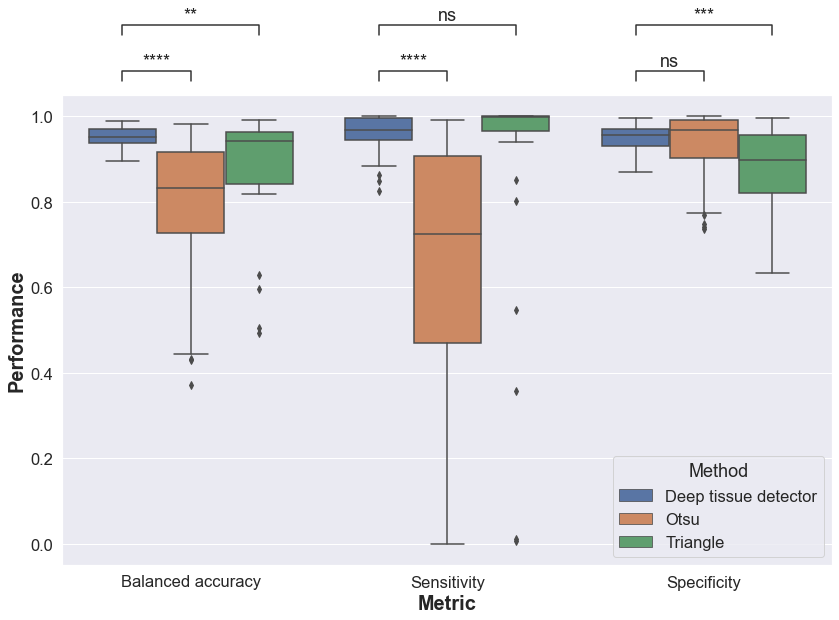

In [6]:
results = pickle.load(open("/home/cri.camres.org/berman01/Documents/pathml-tutorial/benchmark_deep_tissue_detector/results.p", 'rb'))

num_cases = len(results['deep_tissue_detector_bal_acc'])

dtt_results = results['deep_tissue_detector_bal_acc']+results['deep_tissue_detector_tissue_rec']+results['deep_tissue_detector_background_rec']
otsu_results = results['otsu_bal_acc']+results['otsu_tissue_rec']+results['otsu_background_rec']
triangle_results = results['triangle_bal_acc']+results['triangle_tissue_rec']+results['triangle_background_rec']
metric_list = ['Balanced accuracy' for i in range(num_cases)]+['Sensitivity' for i in range(num_cases)]+['Specificity' for i in range(num_cases)]

boxplot_df = pd.DataFrame(
    {'Performance':dtt_results+otsu_results+triangle_results,
     'Method':['Deep tissue detector' for i in range(len(dtt_results))]+['Otsu' for i in range(len(otsu_results))]+['Triangle' for i in range(len(triangle_results))],
     'Metric': metric_list+metric_list+metric_list
    })

#print(boxplot_df)

box_pairs = [
    (('Balanced accuracy', 'Deep tissue detector'), ('Balanced accuracy', 'Otsu')),
    (('Balanced accuracy', 'Deep tissue detector'), ('Balanced accuracy', 'Triangle')),
    (('Sensitivity', 'Deep tissue detector'), ('Sensitivity', 'Otsu')),
    (('Sensitivity', 'Deep tissue detector'), ('Sensitivity', 'Triangle')),
    (('Specificity', 'Deep tissue detector'), ('Specificity', 'Otsu')),
    (('Specificity', 'Deep tissue detector'), ('Specificity', 'Triangle'))
]

plt.figure(figsize=(12,9))
sns.set(font_scale=1.5)
ax = sns.boxplot(x='Metric', y='Performance', hue='Method', data=boxplot_df)
ax.set_xlabel('Metric', fontsize=20, fontweight='bold')
ax.set_ylabel('Performance', fontsize=20, fontweight='bold')
annotator = Annotator(ax, pairs=box_pairs, data=boxplot_df, x='Metric', y='Performance', 
                      hue='Method')
annotator.configure(test='Wilcoxon', text_format='star', loc='outside', 
                    comparisons_correction='benjamini-hochberg')
annotator.apply_and_annotate()
plt.tight_layout()
plt.savefig(os.path.join('/Users/berman01/Downloads/plots', 'performance_boxplot.svg'))
plt.show()

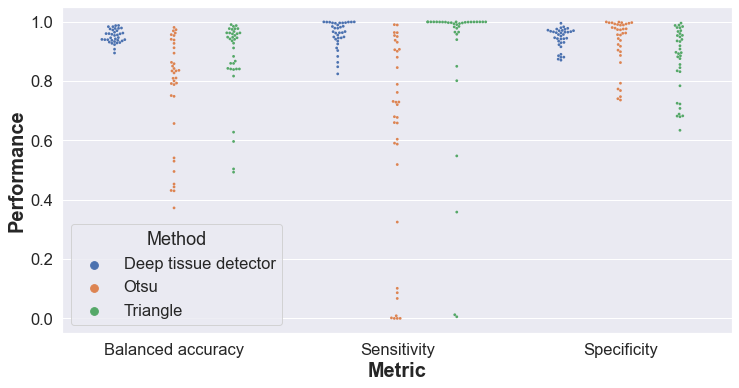

In [76]:
plt.figure(figsize=(12,6))
sns.set(font_scale=1.5)
ax = sns.swarmplot(x='Metric', y='Performance', hue='Method', data=boxplot_df, dodge=True, size=2.79)
ax.set_xlabel('Metric', fontsize=20, fontweight='bold')
ax.set_ylabel('Performance', fontsize=20, fontweight='bold')
plt.savefig(os.path.join('/Users/berman01/Downloads/plots', 'performance_swarmplot.png'))
plt.show()

Wilcoxon two-tailed sign-rank test

In [10]:
results = pickle.load(open("/home/cri.camres.org/berman01/Documents/pathml-tutorial/benchmark_deep_tissue_detector/results.p", 'rb'))
stats.wilcoxon(x=results['deep_tissue_detector_bal_acc'], y=results['triangle_bal_acc'], alternative='two-sided')

WilcoxonResult(statistic=166.0, pvalue=0.008698904000977194)

In [13]:
tile_size = 500 # pixels
tcga_prad_slides = [str(path) for path in Path('/media/berman01/Seagate Expansion Drive/tcga_prad').glob('**/*.svs')]
print(tcga_prad_slides)
for tcga_prad_slide in ['/media/berman01/Seagate Expansion Drive/tcga_prad/TCGA-G9-6333-11A-01-TS1.924c9301-78b6-4330-be95-533b25cf1a91.svs', '/media/berman01/Seagate Expansion Drive/tcga_prad/TCGA-CH-5768-01Z-00-DX1.4c6626ea-a1fb-4aca-8970-a40035025174.svs']:#tcga_prad_slides[22:]:
    path = tcga_prad_slide
    example_slide = Slide(path, level=0).setTileProperties(tileSize=tile_size)
    example_slide.detectForeground(level=2)
    example_slide.detectTissue()

    #for slide in example_slide:
    #example_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))
    example_slide.visualizeThumbnail(folder=os.path.join(analysis_dir_path, 'results'), level=2)
    example_slide.visualizeForeground('otsu', folder=os.path.join(analysis_dir_path, 'results'))
    example_slide.visualizeForeground('triangle', folder=os.path.join(analysis_dir_path, 'results'))
    example_slide.visualizeTissueDetection(folder=os.path.join(analysis_dir_path, 'results'))

[]


FileNotFoundError: Whole-slide image could not be loaded